In [1]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pandas_ta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, RobustScaler
import yfinance as yf

In [38]:
name = 'AAPL'
train_end_date = '2022-01-01'

In [39]:
#get tech stock data
name_ohlc_df = yf.download(name, start='2012-01-01', end=train_end_date)
spy_ohlc_df = yf.download('SPY', start='2012-01-01', end=train_end_date)
msft_ohlc_df = yf.download('MSFT', start='2012-01-01', end=train_end_date)
goog_ohlc_df = yf.download('GOOG', start='2012-01-01', end=train_end_date)
aapl_ohlc_df = yf.download('AAPL', start='2012-01-01', end=train_end_date)
meta_ohlc_df = yf.download('META', start='2012-01-01', end=train_end_date)
amzn_ohlc_df = yf.download('AMZN', start='2012-01-01', end=train_end_date)
nvda_ohlc_df = yf.download('NVDA', start='2012-01-01', end=train_end_date)
intc_ohlc_df = yf.download('INTC', start='2012-01-01', end=train_end_date)
amd_ohlc_df = yf.download('AMD', start='2012-01-01', end=train_end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [40]:
def prepare_dataframe(df,cols_to_use):
    updated_df = df.copy()

    updated_df = updated_df[cols_to_use] 
    upd_scaler = StandardScaler()
    upd_scaler = upd_scaler.fit(updated_df)
    updated_df_scaled = upd_scaler.transform(updated_df)

    X = []
    Y = []
    n_future = 1   # Number of days we want to look into the future based on the past days.
    global n_past
    n_past = 14  # Number of past days we want to use to predict the future.
    for i in range(n_past, len(updated_df_scaled) - n_future + 1,n_future):
        X.append(updated_df_scaled[i - n_past:i, 0:updated_df_scaled.shape[1]])
        Y.append(updated_df_scaled[i:i + n_future, 3]) #index 3 is Close

    return np.array(X), np.array(Y), upd_scaler

In [41]:
#prepare training data
df = name_ohlc_df.copy()
df = df.reset_index().rename(columns={'index': 'Date'})
date_array = df['Date'].to_numpy()
date_series = df['Date']
cols = list(df)[1:]
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Clos
df_for_training = df[cols].astype(float)
df_for_training1 = spy_ohlc_df[cols].astype(float)
df_for_training2 = msft_ohlc_df[cols].astype(float)
df_for_training3 = aapl_ohlc_df[cols].astype(float)
df_for_training4 = nvda_ohlc_df[cols].astype(float)

columns_to_use = ['Open', 'High', 'Low', 'Close', 'Volume']
trainX, trainY, train_scaler = prepare_dataframe(df_for_training,columns_to_use)
trainX1, trainY1, train_scaler = prepare_dataframe(df_for_training1,columns_to_use)
trainX2, trainY2, train_scaler = prepare_dataframe(df_for_training2,columns_to_use)
trainX3, trainY3, train_scaler = prepare_dataframe(df_for_training3,columns_to_use)
trainX4, trainY4, train_scaler = prepare_dataframe(df_for_training4,columns_to_use)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [42]:
def build_lstm_model(input_shape):

    inputs = tf.keras.layers.Input(shape=input_shape)
    lstm_output1 = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
    dropout_output1 = tf.keras.layers.Dropout(0.3)(lstm_output1)  # Adding dropout with a rate of 0.2
    lstm_output2 = tf.keras.layers.LSTM(128, return_sequences=True)(dropout_output1)
    dropout_output2 = tf.keras.layers.Dropout(0.3)(lstm_output2)  
    lstm_output3 = tf.keras.layers.LSTM(128, return_sequences=False)(dropout_output2)
    dropout_output3 = tf.keras.layers.Dropout(0.3)(lstm_output3)  

    flat_mean_output = tf.keras.layers.Dense(5, activation='relu')(dropout_output3) 
    output_mean = tf.keras.layers.Dense(1)(flat_mean_output)  # Output for mean prediction

    model = tf.keras.models.Model(inputs=inputs, outputs=output_mean)

    return model

In [43]:
model = build_lstm_model(input_shape=(n_past, len(columns_to_use)))
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X = np.concatenate((trainX1,trainX2,trainX3,trainX4,trainX),axis=0)
big_train_Y = np.concatenate((trainY1,trainY2,trainY3,trainY4,trainY),axis=0)

In [44]:
history = model.fit(big_train_X, big_train_Y, epochs=20, batch_size=16, validation_split=0.3, verbose=0)

In [ ]:
small_model = build_lstm_model(input_shape=(n_past, len(columns_to_use)))
small_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')

In [ ]:
history2 = small_model.fit(trainX, trainY, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

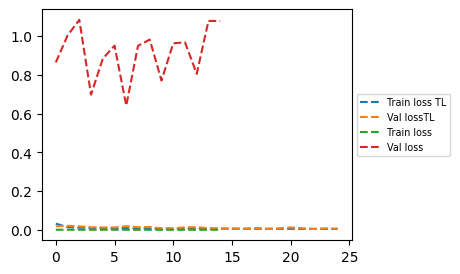

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'],'--', label='Train loss TL')
plt.plot(history.history['val_loss'],'--', label='Val lossTL')
plt.plot(history2.history['loss'],'--', label='Train loss')
plt.plot(history2.history['val_loss'],'--', label='Val loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')
plt.grid()
plt.show()

# Now we've trained, let's infer

In [ ]:
# train_end_date = '2017-12-31'
print(train_end_date)
forecast_df = yf.download(name, start=train_end_date, end='2023-07-01')
forecast_df = forecast_df.reset_index().rename(columns={'index': 'Date'})

2022-01-01
[*********************100%***********************]  1 of 1 completed


In [ ]:
forecast_date_array = forecast_df['Date'].to_numpy()[n_past:]
truth_opens = forecast_df['Open'].values[n_past:]
truth_closes = forecast_df['Close'].values[n_past:]

testX, testY, scaler = prepare_dataframe(forecast_df,columns_to_use)

#predict the open col
forecast = model.predict(testX)
forecast_copies = np.repeat(forecast,len(columns_to_use),axis=-1)
y_pred_model = scaler.inverse_transform(forecast_copies)[:,3]

small_forecast = small_model.predict(testX)
small_forecast_copies = np.repeat(small_forecast,len(columns_to_use),axis=-1)
y_pred_small_model = scaler.inverse_transform(small_forecast_copies)[:,3]


prediction_df = pd.DataFrame({'Date':forecast_date_array,'Close':truth_closes,
                              'Close_pred':y_pred_model, 'Close_small_pred':y_pred_small_model})

 1/12 [=>............................] - ETA: 0s

12/12 [==============================] - 0s 8ms/step


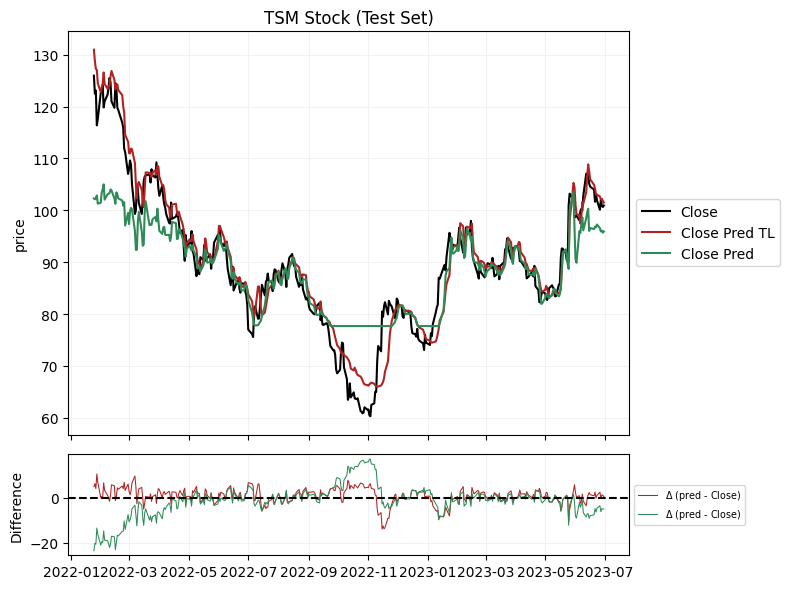

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax[0].plot(prediction_df.Date,prediction_df.Close,label='Close',color='black')

ax[0].plot(prediction_df.Date,prediction_df.Close_pred,label=f'Close Pred TL',color='firebrick')
ax[0].plot(prediction_df.Date,prediction_df.Close_small_pred,label=f'Close Pred',color='seagreen')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel('price')
ax[0].set_title(name +' Stock (Test Set)')
ax[0].grid(color="0.95")

ax[1].plot(prediction_df.Date, prediction_df.Close_pred - prediction_df.Close, color='firebrick',label='$\Delta$ (pred - Close)',lw=0.75)
ax[1].plot(prediction_df.Date, prediction_df.Close_small_pred - prediction_df.Close, color='seagreen',label='$\Delta$ (pred - Close)',lw=0.75)
ax[1].axhline(0,ls='--',color='black')
ax[1].set_ylabel('Difference')
ax[1].grid(color="0.95")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')

plt.tight_layout()
plt.show()